In [1]:
import requests
import numpy as np
import trimesh

# Prepare the matrix

matrix = np.array([[606.7363891601562, 0.0, 317.734130859375], 
                   [0.0, 606.6710205078125, 242.07131958007812], 
                   [0.0, 0.0, 1.0]])
matrix_json = matrix.tolist()


scene_dir = '/home/ubuntu/trlc/data/images/1747013940674'

rgb_path = '/home/ubuntu/trlc/data/images/1747013940674/rgb/1747013940674.png'
depth_path = '/home/ubuntu/trlc/data/images/1747013940674/depth/1747013940674.png'
mask_path = '/home/ubuntu/trlc/data/images/1747013940674/masks/1747013940674.png'

mesh_obj_path = '/home/ubuntu/trlc/data/meshes/lego/LEGO_DUPLO_.obj'
mesh_mtl_path = '/home/ubuntu/trlc/data/meshes/lego/LEGO_DUPLO_.obj.mtl'
mesh_texture_path = '/home/ubuntu/trlc/data/meshes/lego/texture.png'

files = {
    'mesh_obj': open(mesh_obj_path, 'rb'),
    'mesh_mtl': open(mesh_mtl_path, 'rb'),
    'mesh_texture': open(mesh_texture_path, 'rb'),
    'rgb': open(rgb_path, 'rb'),
    'depth': open(depth_path, 'rb'),
    'mask': open(mask_path, 'rb'),
}
data = {
    'cam_K': str(matrix_json)  # or json.dumps(matrix_json)
}

response = requests.post(
    'http://localhost:8000/pose',
    files=files,
    data=data
)

pose =response.json()["pose"]

In [2]:
pose = np.array(pose)
print(pose)

[[-0.48996142 -0.87170357  0.00840561  0.07138196]
 [-0.32576522  0.17414321 -0.9292745   0.03140692]
 [ 0.80858809 -0.45804691 -0.3692942   0.26629561]
 [ 0.          0.          0.          1.        ]]


In [3]:
mesh = trimesh.load(mesh_obj_path)
to_origin, extents = trimesh.bounds.oriented_bounds(mesh)
bbox = np.stack([-extents/2, extents/2], axis=0).reshape(2,3)

In [4]:
center_pose = pose@np.linalg.inv(to_origin)

In [18]:
# from Utils.py
 
import cv2
import imageio
import glob
import os
import logging
import torch
import torch.nn as nn

def project_3d_to_2d(pt,K,ob_in_cam):
  pt = pt.reshape(4,1)
  projected = K @ ((ob_in_cam@pt)[:3,:])
  projected = projected.reshape(-1)
  projected = projected/projected[2]
  return projected.reshape(-1)[:2].round().astype(int)

def draw_xyz_axis(color, ob_in_cam, scale=0.1, K=np.eye(3), thickness=3, transparency=0,is_input_rgb=False):
  '''
  @color: BGR
  '''
  if is_input_rgb:
    color = cv2.cvtColor(color,cv2.COLOR_RGB2BGR)
  xx = np.array([1,0,0,1]).astype(float)
  yy = np.array([0,1,0,1]).astype(float)
  zz = np.array([0,0,1,1]).astype(float)
  xx[:3] = xx[:3]*scale
  yy[:3] = yy[:3]*scale
  zz[:3] = zz[:3]*scale
  origin = tuple(project_3d_to_2d(np.array([0,0,0,1]), K, ob_in_cam))
  xx = tuple(project_3d_to_2d(xx, K, ob_in_cam))
  yy = tuple(project_3d_to_2d(yy, K, ob_in_cam))
  zz = tuple(project_3d_to_2d(zz, K, ob_in_cam))
  line_type = cv2.LINE_AA
  arrow_len = 0
  tmp = color.copy()
  tmp1 = tmp.copy()
  tmp1 = cv2.arrowedLine(tmp1, origin, xx, color=(0,0,255), thickness=thickness,line_type=line_type, tipLength=arrow_len)
  mask = np.linalg.norm(tmp1-tmp, axis=-1)>0
  tmp[mask] = tmp[mask]*transparency + tmp1[mask]*(1-transparency)
  tmp1 = tmp.copy()
  tmp1 = cv2.arrowedLine(tmp1, origin, yy, color=(0,255,0), thickness=thickness,line_type=line_type, tipLength=arrow_len)
  mask = np.linalg.norm(tmp1-tmp, axis=-1)>0
  tmp[mask] = tmp[mask]*transparency + tmp1[mask]*(1-transparency)
  tmp1 = tmp.copy()
  tmp1 = cv2.arrowedLine(tmp1, origin, zz, color=(255,0,0), thickness=thickness,line_type=line_type, tipLength=arrow_len)
  mask = np.linalg.norm(tmp1-tmp, axis=-1)>0
  tmp[mask] = tmp[mask]*transparency + tmp1[mask]*(1-transparency)
  tmp = tmp.astype(np.uint8)
  if is_input_rgb:
    tmp = cv2.cvtColor(tmp,cv2.COLOR_BGR2RGB)

  return tmp

class YcbineoatReader:
  def __init__(self,video_dir, downscale=1, shorter_side=None, zfar=np.inf):
    self.video_dir = video_dir
    self.downscale = downscale
    self.zfar = zfar
    self.color_files = sorted(glob.glob(f"{self.video_dir}/rgb/*.png"))
    self.K = np.loadtxt(f'{video_dir}/cam_K.txt').reshape(3,3)
    self.id_strs = []
    for color_file in self.color_files:
      id_str = os.path.basename(color_file).replace('.png','')
      self.id_strs.append(id_str)
    self.H,self.W = cv2.imread(self.color_files[0]).shape[:2]

    if shorter_side is not None:
      self.downscale = shorter_side/min(self.H, self.W)

    self.H = int(self.H*self.downscale)
    self.W = int(self.W*self.downscale)
    self.K[:2] *= self.downscale

    self.gt_pose_files = sorted(glob.glob(f'{self.video_dir}/annotated_poses/*'))



  def get_video_name(self):
    return self.video_dir.split('/')[-1]

  def __len__(self):
    return len(self.color_files)

  def get_gt_pose(self,i):
    try:
      pose = np.loadtxt(self.gt_pose_files[i]).reshape(4,4)
      return pose
    except:
      logging.info("GT pose not found, return None")
      return None


  def get_color(self,i):
    color = imageio.imread(self.color_files[i])[...,:3]
    color = cv2.resize(color, (self.W,self.H), interpolation=cv2.INTER_NEAREST)
    return color

  def get_mask(self,i):
    mask = cv2.imread(self.color_files[i].replace('rgb','masks'),-1)
    if len(mask.shape)==3:
      for c in range(3):
        if mask[...,c].sum()>0:
          mask = mask[...,c]
          break
    mask = cv2.resize(mask, (self.W,self.H), interpolation=cv2.INTER_NEAREST).astype(bool).astype(np.uint8)
    return mask

  def get_depth(self,i):
    depth = cv2.imread(self.color_files[i].replace('rgb','depth'),-1)/1e3
    depth = cv2.resize(depth, (self.W,self.H), interpolation=cv2.INTER_NEAREST)
    depth[(depth<0.001) | (depth>=self.zfar)] = 0
    return depth


  def get_xyz_map(self,i):
    depth = self.get_depth(i)
    xyz_map = depth2xyzmap(depth, self.K)
    return xyz_map

  def get_occ_mask(self,i):
    hand_mask_file = self.color_files[i].replace('rgb','masks_hand')
    occ_mask = np.zeros((self.H,self.W), dtype=bool)
    if os.path.exists(hand_mask_file):
      occ_mask = occ_mask | (cv2.imread(hand_mask_file,-1)>0)

    right_hand_mask_file = self.color_files[i].replace('rgb','masks_hand_right')
    if os.path.exists(right_hand_mask_file):
      occ_mask = occ_mask | (cv2.imread(right_hand_mask_file,-1)>0)

    occ_mask = cv2.resize(occ_mask, (self.W,self.H), interpolation=cv2.INTER_NEAREST)

    return occ_mask.astype(np.uint8)

  def get_gt_mesh(self):
    ob_name = self.videoname_to_object[self.get_video_name()]
    YCB_VIDEO_DIR = os.getenv('YCB_VIDEO_DIR')
    mesh = trimesh.load(f'{YCB_VIDEO_DIR}/models/{ob_name}/textured_simple.obj')
    return mesh

def draw_posed_3d_box(K, img, ob_in_cam, bbox, line_color=(0,255,0), linewidth=2):
  '''Revised from 6pack dataset/inference_dataset_nocs.py::projection
  @bbox: (2,3) min/max
  @line_color: RGB
  '''
  min_xyz = bbox.min(axis=0)
  xmin, ymin, zmin = min_xyz
  max_xyz = bbox.max(axis=0)
  xmax, ymax, zmax = max_xyz

  def draw_line3d(start,end,img):
    pts = np.stack((start,end),axis=0).reshape(-1,3)
    pts = (ob_in_cam@to_homo(pts).T).T[:,:3]   #(2,3)
    projected = (K@pts.T).T
    uv = np.round(projected[:,:2]/projected[:,2].reshape(-1,1)).astype(int)   #(2,2)
    img = cv2.line(img, uv[0].tolist(), uv[1].tolist(), color=line_color, thickness=linewidth, lineType=cv2.LINE_AA)
    return img

  for y in [ymin,ymax]:
    for z in [zmin,zmax]:
      start = np.array([xmin,y,z])
      end = start+np.array([xmax-xmin,0,0])
      img = draw_line3d(start,end,img)

  for x in [xmin,xmax]:
    for z in [zmin,zmax]:
      start = np.array([x,ymin,z])
      end = start+np.array([0,ymax-ymin,0])
      img = draw_line3d(start,end,img)

  for x in [xmin,xmax]:
    for y in [ymin,ymax]:
      start = np.array([x,y,zmin])
      end = start+np.array([0,0,zmax-zmin])
      img = draw_line3d(start,end,img)

  return img

def to_homo(pts):
  '''
  @pts: (N,3 or 2) will homogeneliaze the last dimension
  '''
  assert len(pts.shape)==2, f'pts.shape: {pts.shape}'
  homo = np.concatenate((pts, np.ones((pts.shape[0],1))),axis=-1)
  return homo

In [27]:
reader = YcbineoatReader(video_dir=scene_dir, shorter_side=None, zfar=np.inf)
center_pose = pose@np.linalg.inv(to_origin)
vis_bbox = draw_posed_3d_box(reader.K, img=reader.get_color(0), ob_in_cam=center_pose, bbox=bbox)
vis_xyz_axis = draw_xyz_axis(reader.get_color(0), ob_in_cam=center_pose, scale=0.04, K=reader.K, thickness=3, transparency=0, is_input_rgb=True)

/tmp/ipykernel_49472/2802275760.py:104: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  color = imageio.imread(self.color_files[i])[...,:3]


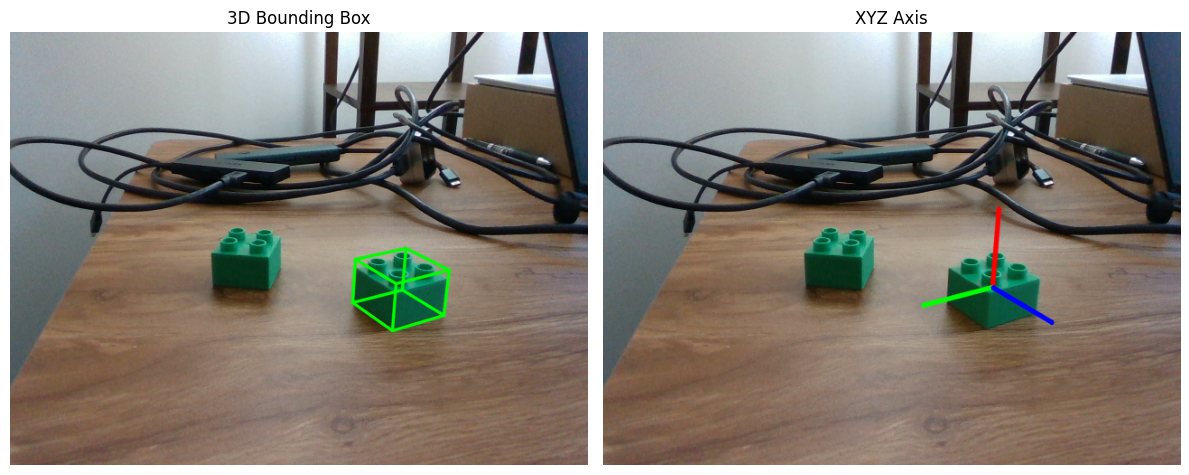

In [30]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(vis_bbox)
axs[0].set_title("3D Bounding Box")
axs[0].axis('off')
axs[1].imshow(vis_xyz_axis)
axs[1].set_title("XYZ Axis")
axs[1].axis('off')
plt.tight_layout()
plt.show()